# Data Workshop 1

The training wheels are off! In this workshop you will read up on the dataset from CRCCNS pvc-6, import the data from h5py into either an xarray object or a pandas object, and plot first the raw data, and then averaged data with uncertainty measures. 

Our goal is to generate a few plots based on this data set

1. Using the constant current inputs: a plot of firing rate vs. current input for both cell types & stimulus types (constant vs white noise)
2. Using the ramping inputs: a plot of frequency vs. current input for both cell types. 

The gameplan is

1. Load data using h5py
2. Create some exploratory plots
3. Create pandas DataFrame for stimuli
4. Create xarrays for recordings
5. Create pandas DataFrame for responses
5. Using steps: Create plot of firing rate vs I (step & noise, both cells) 
6. Using ramps: Create plot of f vs I (both cells)



## Setup notebook

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import xarray as xr
import os

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')


In [11]:
h5data1 = h5py.File(os.path.join("..", "data", "allen_data", "151145.04_Data.h5"), 'r')
h5data2 = h5py.File(os.path.join("..", "data", "allen_data", "153098.04.02_data.h5"), 'r')

In [12]:
h5data1.visit(print)

Sweep_0
Sweep_1
Sweep_10
Sweep_11
Sweep_12
Sweep_13
Sweep_14
Sweep_15
Sweep_16
Sweep_17
Sweep_18
Sweep_19
Sweep_2
Sweep_20
Sweep_21
Sweep_22
Sweep_23
Sweep_24
Sweep_25
Sweep_26
Sweep_27
Sweep_28
Sweep_29
Sweep_3
Sweep_30
Sweep_31
Sweep_32
Sweep_33
Sweep_34
Sweep_35
Sweep_36
Sweep_37
Sweep_38
Sweep_39
Sweep_4
Sweep_40
Sweep_41
Sweep_42
Sweep_43
Sweep_44
Sweep_45
Sweep_46
Sweep_47
Sweep_48
Sweep_49
Sweep_5
Sweep_50
Sweep_51
Sweep_52
Sweep_53
Sweep_54
Sweep_55
Sweep_56
Sweep_57
Sweep_58
Sweep_59
Sweep_6
Sweep_60
Sweep_61
Sweep_62
Sweep_63
Sweep_64
Sweep_65
Sweep_66
Sweep_67
Sweep_68
Sweep_69
Sweep_7
Sweep_70
Sweep_71
Sweep_72
Sweep_73
Sweep_74
Sweep_75
Sweep_76
Sweep_77
Sweep_78
Sweep_79
Sweep_8
Sweep_80
Sweep_81
Sweep_82
Sweep_83
Sweep_84
Sweep_85
Sweep_86
Sweep_87
Sweep_88
Sweep_89
Sweep_9
Sweep_90
Sweep_91
qcBridge Bal Enable
qcBridge Bal Value
qcI-Clamp Holding Enable
qcI-Clamp Holding Level
qcNeut Cap Enabled
qcNeut Cap Value
qcSweep_key


In [13]:
h5data2.visit(print)

Sweep_0
Sweep_1
Sweep_10
Sweep_11
Sweep_12
Sweep_13
Sweep_14
Sweep_15
Sweep_16
Sweep_17
Sweep_18
Sweep_19
Sweep_2
Sweep_20
Sweep_21
Sweep_22
Sweep_23
Sweep_24
Sweep_25
Sweep_26
Sweep_27
Sweep_28
Sweep_29
Sweep_3
Sweep_30
Sweep_31
Sweep_32
Sweep_33
Sweep_34
Sweep_35
Sweep_36
Sweep_37
Sweep_38
Sweep_39
Sweep_4
Sweep_40
Sweep_41
Sweep_42
Sweep_43
Sweep_44
Sweep_45
Sweep_46
Sweep_47
Sweep_48
Sweep_49
Sweep_5
Sweep_50
Sweep_51
Sweep_52
Sweep_53
Sweep_54
Sweep_55
Sweep_56
Sweep_57
Sweep_58
Sweep_59
Sweep_6
Sweep_60
Sweep_61
Sweep_62
Sweep_63
Sweep_64
Sweep_65
Sweep_66
Sweep_7
Sweep_8
Sweep_9
qcBridge Bal Enable
qcBridge Bal Value (MOhm)
qcI-Clamp Holding Enable
qcI-Clamp Holding Level (pA)
qcNeut Cap Enable
qcNeut Cap Value (pF)
qcSweep_Key


## Exploratory plotting 

Text(0, 0.5, 'Voltage (mV) / Current (pA)')

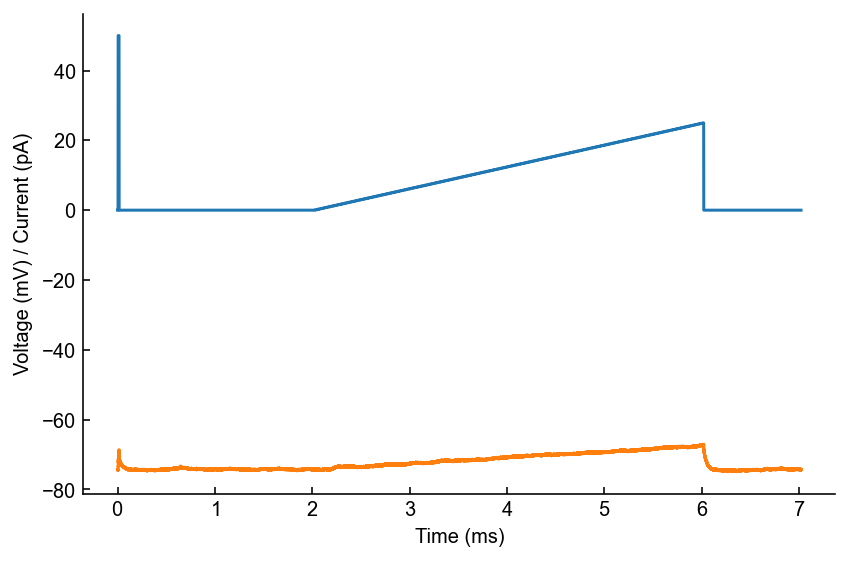

In [15]:
SWEEP_NUM = 0
key = f"Sweep_{SWEEP_NUM}"
current_sweep = np.array(h5data1[key])
# Constructing a time variable, sampling ever 0.005 ms
# Two options
# arange
# T = np.arange()

# linsapce
samples = len(current_sweep)
end_time = samples / 200000.0
T = np.linspace(0, end_time, samples)

fig, ax = plt.subplots()
ax.plot(T, current_sweep)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV) / Current (pA)")

## Create `xarrays` for stimulus and responses

In [16]:
current_sweep_voltage = current_sweep[:,1]
current_sweep_stimulus = current_sweep[:,0]

In [17]:
xr_current_sweep_stimulus = xr.DataArray(current_sweep_stimulus, dims = ("t",), coords = {"t": T})

In [18]:
xr_current_sweep_voltage = xr.DataArray(current_sweep_voltage, dims = ("t",), coords = {"t": T})

In [19]:
xd_current_sweep = xr.Dataset({"stimulus": (('t',),current_sweep_stimulus), 
            "voltage": (('t',), current_sweep_voltage)}, 
           {'t': T})

In [20]:
xd_current_sweep["stimulus"]

<xarray.DataArray 'stimulus' (t: 1404001)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * t        (t) float64 0.0 5e-06 1e-05 1.5e-05 2e-05 ... 7.02 7.02 7.02 7.02

## Create a function to characterize stimuli

In [21]:
# Courtesy of team stimulus (with a few small additions: docstring & kwarg for threshold)

def sweep_descriptives(xarray, true_start=1, threshold=0.01): 
    """
    This function takes an xarray containg a current sweep and retruns a dictionary
    containing some descriptives about the stimulus:
        1. start time
        2. end time
        3. mean
        4. minimum
        5. maximum
    """
    #take the pulse out
    wo_calibration = xarray.loc[true_start:]
    #stimulus on
    stimulus_on = np.abs(wo_calibration) > threshold
    #times when stimulus is on 
    wo_calibration.t[stimulus_on]
    #current value when stimulus is on
    wo_calibration[stimulus_on]
    
    output = {}
    #Start
    stimulus_start = float(wo_calibration.t[stimulus_on][0])
    output["stimulus_start"] = stimulus_start
    #End
    stimulus_end = float(wo_calibration.t[stimulus_on][-1])
    output["stimulus_end"] = stimulus_end
    #Mean
    mean = float(np.mean(wo_calibration[stimulus_on]))
    output["mean"] = mean
    #Min 
    minim = float(np.min(wo_calibration[stimulus_on]))
    output["minim"] = minim
    #Max
    maxim = float(np.max(wo_calibration[stimulus_on]))
    output["maxim"] = maxim
    
    return output

## Create a function to to find spike times and counts

In [22]:
# Courtesy of team response (with a few small additions: docstring & kwarg for 
# spike_cutoff and peak width)
import scipy

def find_spikes(xarray, start_time, end_time, spike_thresh=0, spike_width=200):
    """
    This function takes an xarray of the neural response ands finds all spikes 
    between start_time and end_time. It returns a dictionary containing the 
    spike counts and spike times. 
    """
    during_stimulus = xarray.loc[start_time:end:time]
    spike_indicies = scipy.signal.find_peaks(during_stimulus, height=spike_thresh, distance=spike_width)[0]
    spike_times = during_stimulus.t[spike_indicies]
    spike_count = len(spike_times)
    return {'spike_count': spike_count, 'spike_times': spike_times}

## Create a pandas `DataFrame` with the stimulus descriptives, neural responses, stimulus type indexed by sweep number

In [3]:
# Some lists of each stimulus type
data1_ramps = [0, 1, 2, 68, 69, 70, 71, 72]
data1_steps = [12, 13, 14, 15, 16, 17, 22, 30, 38, 42, 46, 50, 55, 59, 63, 67, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
data1_noise = [18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 39, 40, 41, 43, 44, 45, 47, 48, 49, 56, 57, 58, 60, 61, 62, 64, 65, 66]

# Some lists of each stimulus type
data2_ramps = [0, 1, 55, 56, 57]
data2_steps = [8, 9, 10, 11, 12, 16, 20, 24, 31, 35, 39, 46, 50, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66]
data2_noise = [12, 14, 15, 17, 18, 19, 21, 22, 23, 28, 29, 30, 32, 33, 34, 36, 37, 38, 43, 44, 45, 47, 48, 49, 51, 52, 53]

In [24]:
# 1. create a list that we will store each dictionary in representing a row of 
processed_data = []
# 2. Looping over each group in the data file
for group in h5data1:
    # 3. Creating a dictionary that represnets the current sweep that will eventually be added
    #.   to the list. 
    current_data = {}
    # 4. Check whether the current group is actually a sweep
    # 5. If it is extract the sweep number and find the type of sweep and add these 
    #    to the dictionary. 
    # 6. Describe the current sweep and add that to the dictionary
    # 7. Describe the response and add that to the dictionary 
# 8. Create a pandas DataFrame and set the sweep number as the index

## Using steps: Create plot of firing rate vs I (step & noise, both cells)

## Using ramps: Create plot of f vs I (both cells)